# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
import scipy.stats as stats

from minot.ClusterTools import map_tools
import pitszi

# Test in 1D

In [2]:
#===== Test the value of the mean versus P(k=0)
reso, Nx = 0.1, 10000
mu = 36
f = np.random.normal(mu,1,Nx)
k = np.fft.fftfreq(Nx, reso)
knorm = np.sqrt(k**2)
fourier_img = np.fft.fft(f)
fourier_pk = np.abs(fourier_img)**2
(fourier_pk[knorm == 0])**0.5/Nx

array([35.99076326])

In [3]:
#===== Test FFT calculation
signal = np.random.normal(0,1,Nx)

k = np.fft.fftfreq(Nx, reso)
x = k*reso**2*Nx
Iks = np.zeros(Nx)
for m in range(Nx):
    Iks[m] = np.abs(np.sum(np.exp(-2j*np.pi * x[m]*k)*signal))
    
Iks / np.abs(np.fft.fft(signal))

array([1., 1., 1., ..., 1., 1., 1.])

In [4]:
########################
def extract_pk1d(data, reso, Nbin=50, scalebin='lin'):
    Nx = len(data)
    # Define the k_i and k_norm
    k_x = np.fft.fftfreq(Nx, reso)
    k_norm = np.sqrt(k_x**2)
    # Compute the Pk amplitide
    fourier_img = np.fft.fft(data)
    fourier_pk = np.abs(fourier_img)**2 # img unit squared
    # bining
    kmax_sampling = np.amax(k_norm)
    kmin_sampling = np.amin(k_norm[k_norm > 0])
    if scalebin == 'lin':
        kbins = np.linspace(kmin_sampling, kmax_sampling, Nbin+1)
    if scalebin == 'log':
        kbins = np.logspace(np.log10(kmin_sampling), np.log10(kmax_sampling), Nbin+1)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    # Bin the Pk
    Pk_bins, _, _ = stats.binned_statistic(k_norm, fourier_pk, statistic='mean', bins=kbins)
    Pk_bins *= reso / Nx # img unit squared x reso unit squared
    return kvals, Pk_bins

########################
def func_pk(kin, mean=1):
    func = 1e-3*kin**-1 * np.exp(-kin/1) - 4e-3*np.exp(-(kin-1e-1)**2/(1e-1)**2) + 4e-5*np.exp(-(kin-3)**2/(0.6)**2)
    func = func*5e1
    func[kin == 0] = 0 #(mean*Nx)**2*reso
    return func

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


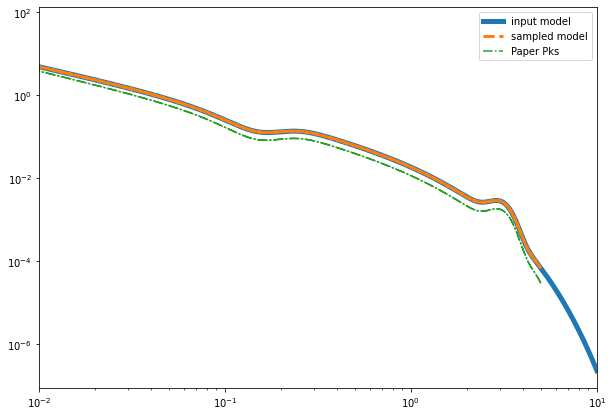

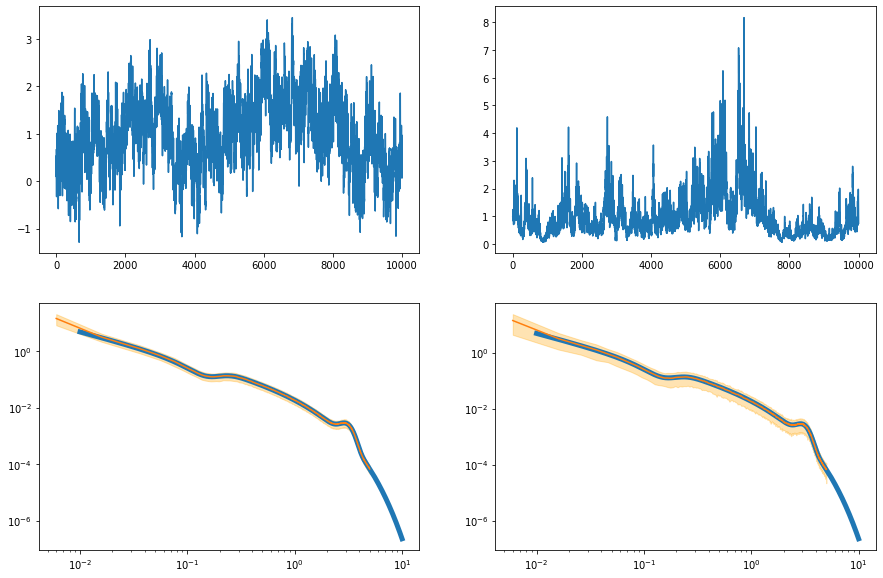

In [5]:
########################
def get_pks_from_pkr(Nx, reso, Pkr):
    n = np.linspace(-Nx/2, Nx/2-1, Nx)
    x = n * reso
    k = n / (Nx*reso)
    xnorm = np.abs(x)
    knorm = np.abs(k)
    Vx = reso
    Vk = 1 / (Nx*reso)
    
    Iks = np.zeros(Nx) + 1j*np.zeros(Nx)
    for m in range(Nx):
        Iks[m] = np.sum(Vk*np.exp(-2j*np.pi * x[m]*k) * Pkr) + 1 #Add P[k=0] to have mean=1, i.e. Vk*Nx*reso
    Iks = np.abs(Iks)

    Pks = np.zeros(Nx)
    for m in range(Nx):
        Pks[m] = np.sum(Vx*np.exp(2j*np.pi * x*k[m]) * np.log(Iks))
    Pks[k == 0] = 0 # Set the mean to zero and define it in real space                  
    Pks = np.abs(Pks)

    # Get conversion Pks Pkr FFT
    #k2 = np.fft.fftfreq(Nx, reso)
    #knorm2 = np.abs(k2)
    #pkrho2 = func_pk(knorm2)
    #Iks2 = np.fft.fftn(pkrho2)
    #Pks2 = np.abs(np.fft.ifftn(np.log(Iks2)))
    
    return Pks

def application(pkrho, Pks, reso, Nx):
    amplitude_g =  np.sqrt(np.fft.fftshift(pkrho) / reso)
    field_g = np.random.normal(loc=0, scale=1, size=Nx)
    fftfield_g = np.fft.fftn(field_g) * amplitude_g
    fluctuation_g = np.real(np.fft.ifftn(fftfield_g)) + 1

    amplitude_ln =  np.sqrt(np.fft.fftshift(Pks) / reso)
    field_ln = np.random.normal(loc=0, scale=1, size=Nx)
    fftfield_ln = np.fft.fftn(field_ln) * amplitude_ln
    fluctuation_ln = np.real(np.fft.ifftn(fftfield_ln))
    #print(np.mean(fluctuation_ln), np.std(fluctuation_ln), np.sqrt(np.mean(amplitude_ln**2)))
    #fluctuation_ln -= (np.mean(fluctuation_ln) + np.std(fluctuation_ln)**2/2)
    fluctuation_ln -= np.mean(amplitude_ln**2)/2 # the mean is define according to ln distrib, i.e. -std^2/2
    fluctuation_ln = np.exp(fluctuation_ln)
    
    kmeas, pkmeas_g  = extract_pk1d(fluctuation_g, reso, Nbin=500)
    kmeas, pkmeas_ln = extract_pk1d(fluctuation_ln, reso, Nbin=500)
    
    #print('Gaussian fluctuation mean:', np.mean(fluctuation_g))
    #print('LN fluctuation mean:', np.mean(fluctuation_ln))

    return fluctuation_g, fluctuation_ln, kmeas, pkmeas_g, pkmeas_ln

########################
#===== Param
reso = 0.1
Nx = 10000

#===== get conversion Pks Pkr
n = np.linspace(-Nx/2, Nx/2-1, Nx)
x = n * reso
k = n / (Nx*reso)
xnorm = np.abs(x)
knorm = np.abs(k)

pkrho = func_pk(knorm)
Pks = get_pks_from_pkr(Nx, reso, pkrho)

#----- Plot Pk
kin  = np.logspace(-2,1,1000)
plt.figure(0, figsize=(10,7))
plt.loglog(kin, func_pk(kin), lw=5, label='input model')
plt.loglog(knorm, pkrho, lw=3, ls='--', label='sampled model')
plt.loglog(knorm, Pks, ls='-.', label='Paper Pks')
#plt.loglog(knorm2, Pks2, ls='', marker='o', label='FFT Pks')
plt.xlim(1e-2,10)
#plt.ylim(1e-8,1)
plt.legend()

# Monte Carlo
Nmc = 1000
pkg_mc = np.zeros((Nmc, 500))
pkln_mc = np.zeros((Nmc, 500))
for i in range(Nmc):
    fluctuation_g, fluctuation_ln, kmeas, pkmeas_g, pkmeas_ln = application(pkrho, Pks, reso, Nx)
    pkg_mc[i,:] = pkmeas_g
    pkln_mc[i,:] = pkmeas_ln

#----- Plots
plt.figure(2, figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(fluctuation_g)
plt.subplot(2,2,2)
plt.plot(fluctuation_ln)
plt.subplot(2,2,3)
plt.loglog(kin, func_pk(kin), lw=5, label='input model')
plt.loglog(kmeas, np.mean(pkg_mc, axis=0))
plt.fill_between(kmeas, np.mean(pkg_mc, axis=0)+np.std(pkg_mc, axis=0), 
                 np.mean(pkg_mc, axis=0)-np.std(pkg_mc, axis=0), color='orange', alpha=0.3)
plt.subplot(2,2,4)
plt.loglog(kin, func_pk(kin), lw=5, label='input model')
plt.loglog(kmeas, np.mean(pkln_mc, axis=0))
plt.fill_between(kmeas, np.mean(pkln_mc, axis=0)+np.std(pkln_mc, axis=0), 
                 np.mean(pkln_mc, axis=0)-np.std(pkln_mc, axis=0), color='orange', alpha=0.3)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in reciprocal


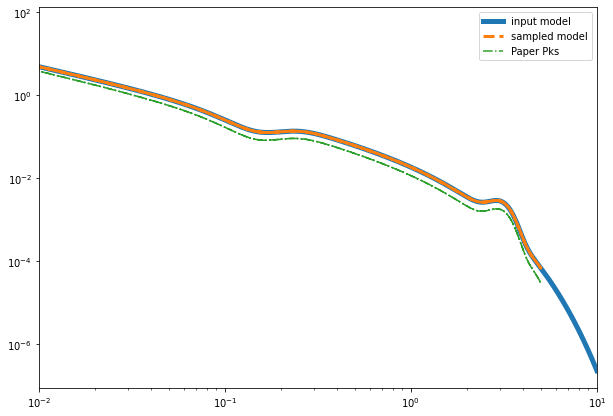

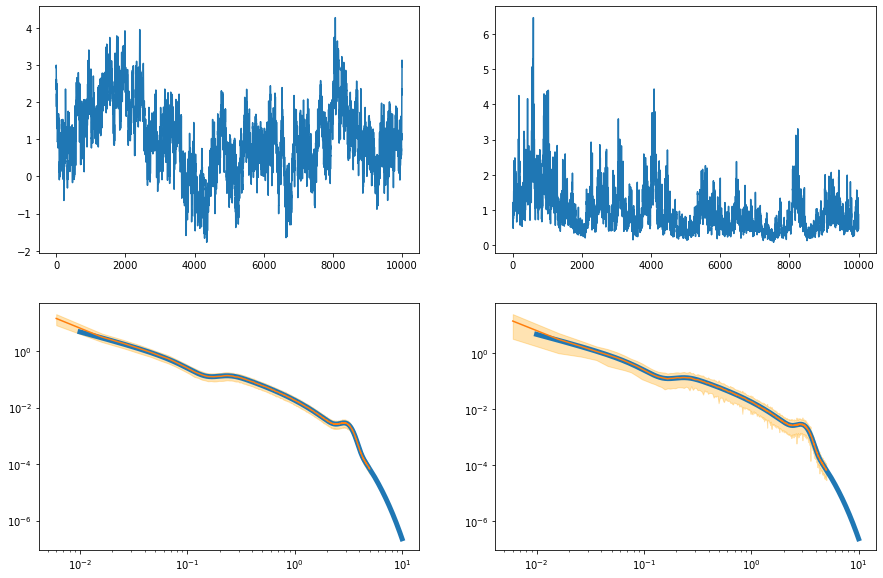

In [6]:
########################
def get_pks_from_pkr(Nx, reso, Pkr):
    Vx = reso
    Vk = 1 / (Nx*reso)
    Iks = np.abs(np.fft.fft(pkrho)*Vk + 1)    
    Pks = np.abs(np.fft.ifft(np.log(Iks))*Vx*Nx)
    Pks[k == 0] = 0
    return Pks

def application(pkrho, Pks, reso, Nx):
    amplitude_g =  np.sqrt(pkrho / reso)
    field_g = np.random.normal(loc=0, scale=1, size=Nx)
    fftfield_g = np.fft.fftn(field_g) * amplitude_g
    fluctuation_g = np.real(np.fft.ifftn(fftfield_g)) + 1

    amplitude_ln =  np.sqrt(Pks / reso)
    field_ln = np.random.normal(loc=0, scale=1, size=Nx)
    fftfield_ln = np.fft.fftn(field_ln) * amplitude_ln
    fluctuation_ln = np.real(np.fft.ifftn(fftfield_ln))
    fluctuation_ln -= np.mean(amplitude_ln**2)/2
    fluctuation_ln = np.exp(fluctuation_ln)
    
    kmeas, pkmeas_g  = extract_pk1d(fluctuation_g, reso, Nbin=500)
    kmeas, pkmeas_ln = extract_pk1d(fluctuation_ln, reso, Nbin=500)

    return fluctuation_g, fluctuation_ln, kmeas, pkmeas_g, pkmeas_ln

########################
#===== Param
reso = 0.1
Nx = 10000

#===== get conversion Pks Pkr
k = np.fft.fftfreq(Nx, reso)
knorm = np.abs(k)

pkrho = func_pk(knorm)
Pks = get_pks_from_pkr(Nx, reso, pkrho)

#----- Plot Pk
kin  = np.logspace(-2,1,1000)
plt.figure(0, figsize=(10,7))
plt.loglog(kin, func_pk(kin), lw=5, label='input model')
plt.loglog(knorm, pkrho, lw=3, ls='--', label='sampled model')
plt.loglog(knorm, Pks, ls='-.', label='Paper Pks')
plt.xlim(1e-2,10)
plt.legend()

# Monte Carlo
Nmc = 1000
pkg_mc = np.zeros((Nmc, 500))
pkln_mc = np.zeros((Nmc, 500))
for i in range(Nmc):
    fluctuation_g, fluctuation_ln, kmeas, pkmeas_g, pkmeas_ln = application(pkrho, Pks, reso, Nx)
    pkg_mc[i,:] = pkmeas_g
    pkln_mc[i,:] = pkmeas_ln

#----- Plots
plt.figure(2, figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(fluctuation_g)
plt.subplot(2,2,2)
plt.plot(fluctuation_ln)
plt.subplot(2,2,3)
plt.loglog(kin, func_pk(kin), lw=5, label='input model')
plt.loglog(kmeas, np.mean(pkg_mc, axis=0))
plt.fill_between(kmeas, np.mean(pkg_mc, axis=0)+np.std(pkg_mc, axis=0), 
                 np.mean(pkg_mc, axis=0)-np.std(pkg_mc, axis=0), color='orange', alpha=0.3)
plt.subplot(2,2,4)
plt.loglog(kin, func_pk(kin), lw=5, label='input model')
plt.loglog(kmeas, np.mean(pkln_mc, axis=0))
plt.fill_between(kmeas, np.mean(pkln_mc, axis=0)+np.std(pkln_mc, axis=0), 
                 np.mean(pkln_mc, axis=0)-np.std(pkln_mc, axis=0), color='orange', alpha=0.3)

# Test in 3D

### Parameters

In [38]:
Linj = 800
Ldis = 10
slope = -11.0/3
Norm = 0.5

In [39]:
proj_reso = 20
los_reso = 25
Nx = 21
Ny = 31
Nz = 11

print(proj_reso*Nz, los_reso*Nx, los_reso*Ny)
print(1/(proj_reso*Nz), 1/(los_reso*Nx), 1/(los_reso*Ny))
print(1/(proj_reso), 1/(los_reso), 1/(los_reso))

220 525 775
0.004545454545454545 0.0019047619047619048 0.0012903225806451613
0.05 0.04 0.04


### Input Pk

In [40]:
def get_pk3d_in(kin=np.logspace(-4, 0, 1000)):
    
    # get the norm
    kin0 = np.logspace(-4, 0, 1000)
    f_k = kin0**slope * np.exp(-(1/(kin0*Linj)**2)) * np.exp(-(kin0*Ldis)**2)
    Normalization = pitszi.utils.trapz_loglog(4*np.pi*kin0**2 * f_k, kin0)
    
    # full Pk
    f_k = kin**slope * np.exp(-(1/(kin*Linj)**2)) * np.exp(-(kin*Ldis)**2)
    P3d_k = Norm**2 * f_k / Normalization
    
    return P3d_k

### Generate normal field

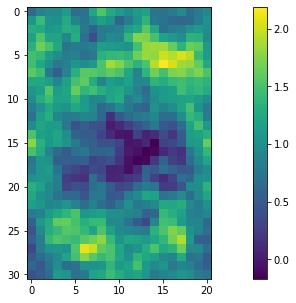

In [41]:
def get_gauss_field():
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    k3d_z, k3d_y, k3d_x = np.meshgrid(k_z, k_y, k_x, indexing='ij')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    k3d_norm_flat = k3d_norm.flatten()                      # Flatten the k3d array
    idx_sort = np.argsort(k3d_norm_flat)                    # Get the sorting index
    revidx = np.argsort(idx_sort)                           # Index to invert rearange by sorting
    k3d_norm_flat_sort = np.sort(k3d_norm_flat)             # Sort the k array
    P3d_flat_sort = get_pk3d_in(k3d_norm_flat_sort[1:])
    P3d_flat_sort = P3d_flat_sort                           # Take the unit out
    P3d_flat_sort = np.append(np.array([0]), P3d_flat_sort) # Add P(k=0) = 0 back
    P3d_flat = P3d_flat_sort[revidx]                        # Unsort
    P3d_k_grid = P3d_flat.reshape(Nz,Ny,Nx)                 # Unflatten to k cube

    amplitude =  np.sqrt(P3d_k_grid / (proj_reso*proj_reso*los_reso))
    field = np.random.normal(loc=0, scale=1, size=(Nz,Ny,Nx))
    fftfield = np.fft.fftn(field) * amplitude
    fluctuation_cube = np.real(np.fft.ifftn(fftfield)) + 1
    return fluctuation_cube
    
plt.figure(0, figsize=(15,5))
plt.imshow(get_gauss_field()[0,:,:])
plt.colorbar()

### Generate lognormal field

In [42]:
def pkrho2pks(Pkr, proj_reso, los_reso):
    Nz, Ny, Nx = Pkr.shape
    Vx = proj_reso**2 * los_reso
    Vk = 1 / (Nx*Ny*Nz*Vx)
    
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)
    k3d_z, k3d_y, k3d_x = np.meshgrid(k_z, k_y, k_x, indexing='ij')
    knorm = (k3d_z**2 + k3d_y**2 + k3d_x**2)**0.5
    
    Iks = np.abs(np.fft.fftn(Pkr)*Vk + 1)    
    Pks = np.abs(np.fft.ifftn(np.log(Iks))*Vx*Nx*Ny*Nz)
    
    Pks[knorm == 0] = 0
    
    return Pks

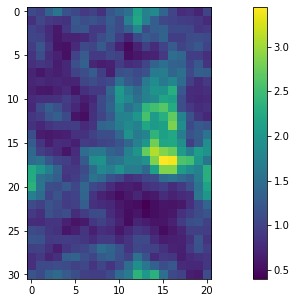

In [43]:
def get_ln_field():
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    k3d_z, k3d_y, k3d_x = np.meshgrid(k_z, k_y, k_x, indexing='ij')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    k3d_norm_flat = k3d_norm.flatten()                      # Flatten the k3d array
    idx_sort = np.argsort(k3d_norm_flat)                    # Get the sorting index
    revidx = np.argsort(idx_sort)                           # Index to invert rearange by sorting
    k3d_norm_flat_sort = np.sort(k3d_norm_flat)             # Sort the k array
    P3d_flat_sort = get_pk3d_in(k3d_norm_flat_sort[1:])
    P3d_flat_sort = P3d_flat_sort                           # Take the unit out
    P3d_flat_sort = np.append(np.array([0]), P3d_flat_sort) # Add P(k=0) = 0 back
    P3d_flat = P3d_flat_sort[revidx]                        # Unsort
    P3d_k_grid = P3d_flat.reshape(Nz,Ny,Nx)                 # Unflatten to k cube
    
    P3d_k_grid_lin = pkrho2pks(P3d_k_grid, proj_reso, los_reso)
     
    amplitude =  np.sqrt(P3d_k_grid_lin / (proj_reso*proj_reso*los_reso))
    field = np.random.normal(loc=0, scale=1, size=(Nz,Ny,Nx))
    fftfield = np.fft.fftn(field) * amplitude
    fluctuation_cube = np.real(np.fft.ifftn(fftfield))
    fluctuation_cube -= np.mean(amplitude**2)/2
    ln_fluctuation_field = np.exp(fluctuation_cube)    
    return ln_fluctuation_field
    
plt.figure(0, figsize=(15,5))
plt.imshow(get_ln_field()[0,:,:])
plt.colorbar()

In [44]:
    k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
    k_y = np.fft.fftfreq(Ny, proj_reso)
    k_z = np.fft.fftfreq(Nz, los_reso)

    k3d_z, k3d_y, k3d_x = np.meshgrid(k_z, k_y, k_x, indexing='ij')
    k3d_norm = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)
    
    r_x = k_x * Nx * proj_reso**2
    r_y = k_y * Ny * proj_reso**2
    r_z = k_z * Nz * los_reso**2
    r3d_z, r3d_y, r3d_x = np.meshgrid(r_z, r_y, r_x, indexing='ij')

    Vx = proj_reso*proj_reso*los_reso
    Vk = 1 / (Nx*Ny*Nz*Vx)
    
    k3d_norm_flat = k3d_norm.flatten()                      # Flatten the k3d array
    idx_sort = np.argsort(k3d_norm_flat)                    # Get the sorting index
    revidx = np.argsort(idx_sort)                           # Index to invert rearange by sorting
    k3d_norm_flat_sort = np.sort(k3d_norm_flat)             # Sort the k array
    P3d_flat_sort = get_pk3d_in(k3d_norm_flat_sort[1:])
    P3d_flat_sort = P3d_flat_sort                           # Take the unit out
    P3d_flat_sort = np.append(np.array([0]), P3d_flat_sort) # Add P(k=0) = 0 back
    P3d_flat = P3d_flat_sort[revidx]                        # Unsort
    P3d_k_grid = P3d_flat.reshape(Nz,Ny,Nx)                 # Unflatten to k cube
    
    P3d_k_grid_lin = pkrho2pks(P3d_k_grid, proj_reso, los_reso)

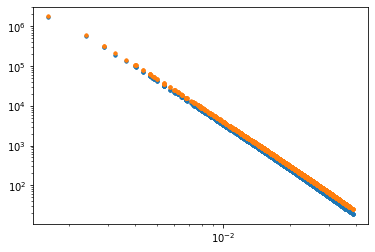

In [45]:
#plt.loglog(k3d_norm_flat, (k3d_norm_flat**3*P3d_k_grid_lin.flatten())**0.5, marker='.', ls='')
#plt.loglog(k3d_norm_flat, (k3d_norm_flat**3*P3d_k_grid.flatten())**0.5, ls='', marker='.')
plt.loglog(k3d_norm_flat, P3d_k_grid_lin.flatten(), marker='.', ls='')
plt.loglog(k3d_norm_flat, P3d_k_grid.flatten(), ls='', marker='.')

### Check that the input Pk agrees with output

In [46]:
Nbin = 100
kmin = 0
kmax = None

(0.01, 10.0)

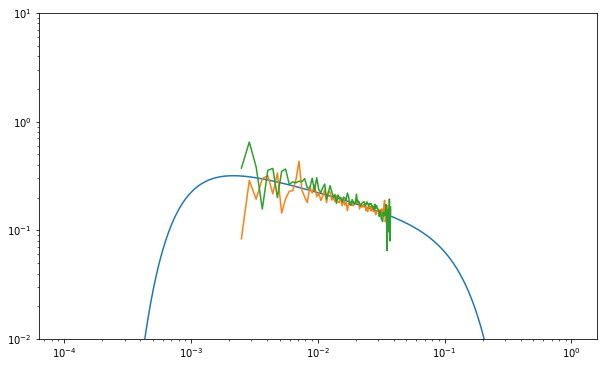

In [55]:
kout, pkout = pitszi.utils_pk.extract_pk3d(get_gauss_field(), proj_reso, los_reso,
                                           Nbin=Nbin, scalebin='lin',
                                           kmin=kmin, kmax=kmax,
                                           statistic='mean')
kout, pkout_ln = pitszi.utils_pk.extract_pk3d(get_ln_field(), proj_reso, los_reso,
                                           Nbin=Nbin, scalebin='lin',
                                           kmin=kmin, kmax=kmax,
                                           statistic='mean')

kin = np.logspace(-4, 0, 1000)
pkin = get_pk3d_in(kin)

plt.figure(0, figsize=(10,6))
plt.loglog(kin, np.sqrt(4*np.pi*kin**3*pkin))
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*pkout))
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*pkout_ln))
plt.ylim(1e-2,1e1)

In [51]:
Nmc = 1000
pkout_mc = np.zeros((Nmc, Nbin))
pkoutln_mc = np.zeros((Nmc, Nbin))
for imc in range(Nmc):
    kout, pkout_i = pitszi.utils_pk.extract_pk3d(get_gauss_field(), proj_reso, los_reso,
                                                 Nbin=Nbin, scalebin='lin', kmin=kmin, kmax=kmax,
                                                 statistic='mean')
    pkout_mc[imc] = pkout_i
    
    kout, pkoutln_i = pitszi.utils_pk.extract_pk3d(get_ln_field(), proj_reso, los_reso,
                                                 Nbin=Nbin, scalebin='lin', kmin=kmin, kmax=kmax,
                                                 statistic='mean')
    pkoutln_mc[imc] = pkoutln_i

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


(0.01, 10.0)

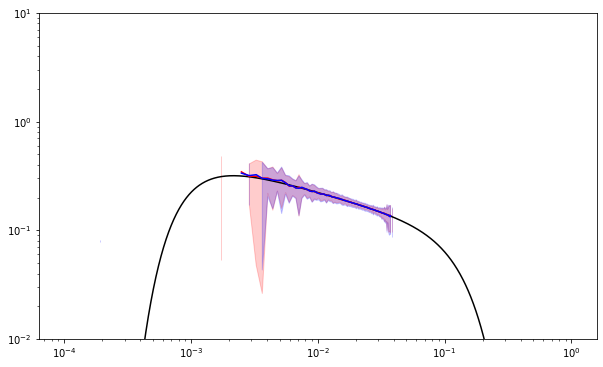

In [56]:
plt.figure(0, figsize=(10,6))
plt.loglog(kin, np.sqrt(4*np.pi*kin**3*pkin), color='k')
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*np.mean(pkout_mc, axis=0)), color='r')
plt.fill_between(kout,
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkout_mc, axis=0)+1*np.std(pkout_mc, axis=0))),
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkout_mc, axis=0)-1*np.std(pkout_mc, axis=0))), 
                 color='r', alpha=0.2)
plt.loglog(kout, np.sqrt(4*np.pi*kout**3*np.mean(pkoutln_mc, axis=0)), color='b')
plt.fill_between(kout,
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkoutln_mc, axis=0)+1*np.std(pkoutln_mc, axis=0))),
                 np.sqrt(4*np.pi*kout**3*(np.mean(pkoutln_mc, axis=0)-1*np.std(pkoutln_mc, axis=0))), 
                 color='b', alpha=0.2)

plt.ylim(1e-2,1e1)

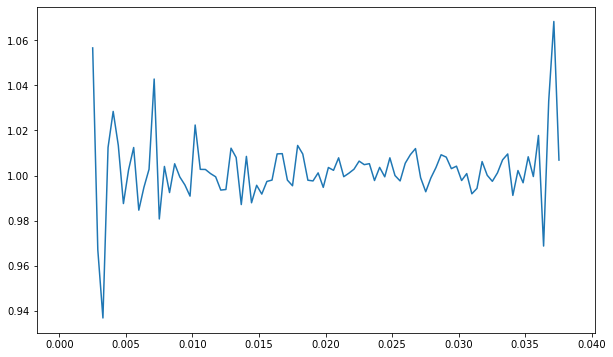

In [57]:
plt.figure(0, figsize=(10,6))
plt.plot(kout, np.mean(pkout_mc, axis=0) / np.mean(pkoutln_mc, axis=0))

# Implementation in PITSZI

In [24]:
c = pitszi.Model(redshift=0.5, M500=1e15*u.Msun)
c.los_reso  = 100*u.kpc
c.los_size  = 2*u.Mpc
c.map_fov = 5*u.arcmin
c.map_reso = 5*u.arcsec

_,_,_, reso_proj, _, reso_los = c.get_3dgrid()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Model                            
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
Setting the l.o.s. resolution value
Setting the l.o.s size value
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand


Setting model_pressure_fluctuation value
Fixing: R500 if involved
----- INFO: fluctuation cube rms.
            Expected rms over the full k range: 0.5
            Expected rms given the missing k range: 0.43784443731706785
            Actual rms for this noise realization: 0.4511558688192981


(0.01, 1)

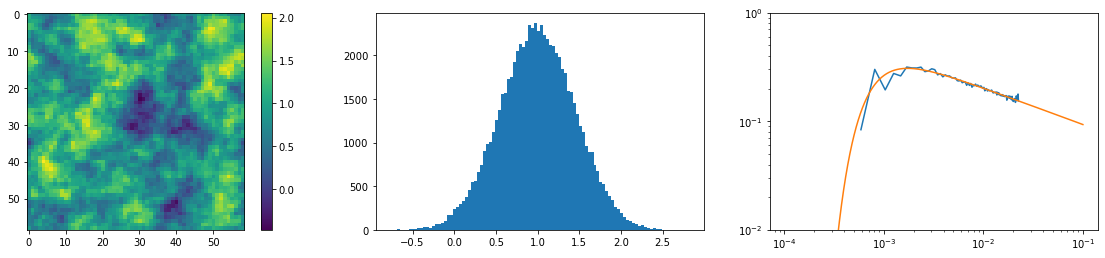

In [29]:
c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'statistics':'gaussian',
                                'Norm': 0.5,
                                'slope': -11/3.0,
                                'Linj': 1*u.Mpc,
                                'Ldis': 1*u.kpc}

c._model_pressure_fluctuation

p_cube = c.get_pressure_cube_fluctuation()+1
k, pk = pitszi.utils_pk.extract_pk3d(p_cube, reso_proj, reso_los, Nbin=100)

plt.figure(0, figsize=(20,4))
plt.subplot(1,3,1)
plt.imshow(p_cube[0,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.hist(p_cube.flatten(), bins=100)
plt.subplot(1,3,3)
plt.loglog(k, np.sqrt(4*np.pi*k**3*pk))
kin, pkin = c.get_pressure_fluctuation_spectrum()
plt.loglog(kin.to_value('kpc-1'), np.sqrt(4*np.pi*kin**3*pkin).to_value(''))
plt.ylim(1e-2,1)

Setting model_pressure_fluctuation value
Fixing: R500 if involved
----- INFO: fluctuation cube rms.
            Expected rms over the full k range: 0.5
            Expected rms given the missing k range: 0.4188202119993237
            Actual rms for this noise realization: 0.42795470862719537


(0.01, 1)

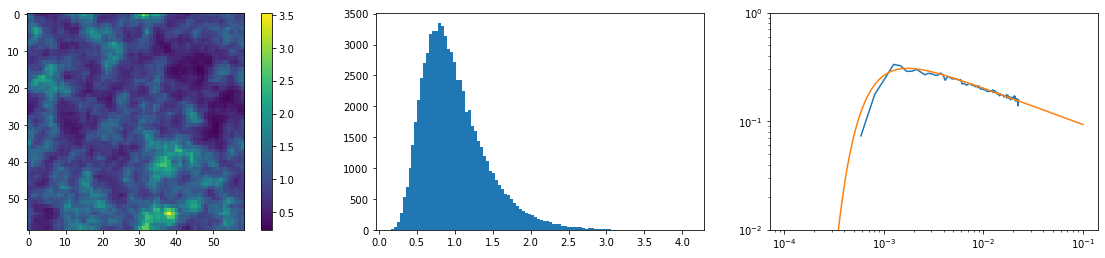

In [38]:
c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'statistics':'lognormal',
                                'Norm': 0.5,
                                'slope': -11/3.0,
                                'Linj': 1*u.Mpc,
                                'Ldis': 1*u.kpc}

p_cube = c.get_pressure_cube_fluctuation()+1
k, pk = pitszi.utils_pk.extract_pk3d(p_cube, reso_proj, reso_los, Nbin=100)

plt.figure(0, figsize=(20,4))
plt.subplot(1,3,1)
plt.imshow(p_cube[0,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.hist(p_cube.flatten(), bins=100)
plt.subplot(1,3,3)
plt.loglog(k, np.sqrt(4*np.pi*k**3*pk))
kin, pkin = c.get_pressure_fluctuation_spectrum()
plt.loglog(kin.to_value('kpc-1'), np.sqrt(4*np.pi*kin**3*pkin).to_value(''))
plt.ylim(1e-2,1)